# It's Week 5!
- My [Trello board](https://trello.com/b/t6j82AJK/senior-design) is looking snazzy
- The pieces are coming together, and the plan is getting clearer and clearer.
- I am ready to clean up this YouTube video into something I can use!
<hr/>

# Tasks:
This week, the goal is to prepare all the parsing code, testing with single images, for next week's mega download.

    1. Download the video from YouTube link ~~to Google Colab~~
    2. Isolate the audio into an `.mp3` file and save ~~to Google Drive~~
    3. Parsing dance clips
    4. Audio will be matched up based on timestamps
    5. Conversion to Binary Image
      - also crop here
    
That's it! Easy! Let's go!

## 1. Download the Video

In [10]:
# Youtube link download
from __future__ import unicode_literals
import youtube_dl
import os

def download_video(url, dest):
    ydl_opts = {
        'outtmpl': os.path.join(dest, '%(title)s.%(ext)s'),
    }
    
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

In [11]:
url = "https://youtu.be/R7qdgPkPsuQ"
dest = "/Users/mkarroqe/Desktop/github/dancing-screen/fortnite_data"
# download_video(url, dest)

## 2. Isolate Audio

In [12]:
# Isolate audio from video to .mp3
import moviepy.editor as mp

def download_audio(url, dest, subclip_stat=False, clip_start=0, clip_end=0):
    if subclip_stat:
        clip = mp.VideoFileClip(url).subclip(clip_start, clip_end)
    else:
        clip = mp.VideoFileClip(url)
    clip.audio.write_audiofile(dest)

In [13]:
url = dest + "/Fortnite All Dances Season 1-11.mp4" 
audio_dest = dest + "/fortnite_audio.wav"
# download_audio(url, audio_dest)

### Spectrogram Viz
I'm curious what it looks like! Maybe the distinction between songs is super clear! <br/>
Source to the madness linked [here](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0).

In [14]:
spect_test = dest + "/test.wav"
# download_audio(url, spect_test, True, 0, 10)
print("Audio downloaded to", spect_test)

Audio downloaded to /Users/mkarroqe/Desktop/github/dancing-screen/fortnite_data/test.wav


In [25]:
import IPython.display as ipd
ipd.Audio(spect_test)

In [15]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

def get_spectrogram(audio_file):
    
#   spectrogram
    y, sr = librosa.load(audio_file)
    plt.figure()
    librosa.display.waveplot(y, sr=sr)
    plt.show()
    
#   Fourier Transform
    n_fft = 2048
    D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft,
                        hop_length=n_fft+1))
    plt.plot(D);
    plt.show()
    
#   Time window no decibels
    hop_length = 512
    D = np.abs(librosa.stft(y, n_fft=n_fft,  
                            hop_length=hop_length))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
    plt.colorbar();
    plt.show()
    
#   Time window yes decibels
    DB = librosa.amplitude_to_db(D, ref=np.max)
    librosa.display.specshow(DB, sr=sr, hop_length=hop_length, 
                             x_axis='time', y_axis='log');
    plt.colorbar(format='%+2.0f dB');
    plt.show()

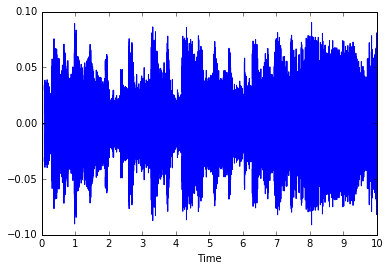

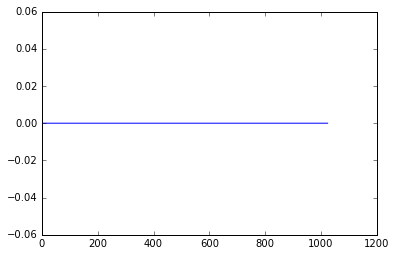

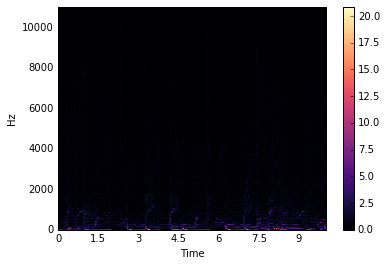

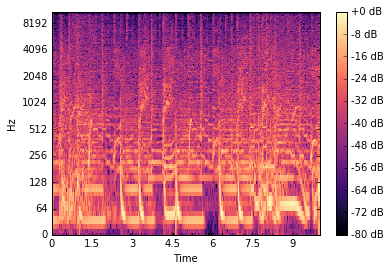

In [16]:
get_spectrogram(spect_test)

OverflowError: In draw_markers: Exceeded cell block limit

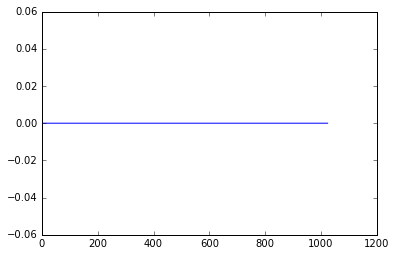

KeyboardInterrupt: 

In [43]:
get_spectrogram(audio_dest)

## 3. Parsing Dance Clips
- This won't be exact because the different "scenes" vary from ~12-25 seconds
- Hopefully it doesn't matter
- Video is at 60fps, for 3112 seconds ==> 186,720 frames
- That is too many
- Let's pull 2fps ==> 6224 frames
- When we pull the frames, timestamp should also be saved

In [17]:
# Save frames in df with timestamps
import cv2

def get_frames(source, dest):
    cap = cv2.VideoCapture(url)
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if i > 500:
            break
        
        output = dest + "test_" + str(i) + ".jpg"
        cv2.imwrite(output, frame)
        i += 1

    cap.release()
    cv2.destroyAllWindows()

In [18]:
ROOT = "/Users/mkarroqe/Desktop/github/dancing-screen/fortnite_data/"
dest = ROOT + "frames/test3/"
# get_frames(url, dest)

## 4. Audio Timestamp Match-Up

In [19]:
# Match up audio via timestamps in df
# Can do this in the filenames above

## 5. Conversion to Binary Image
- Up the contrast 100% (whatever Google Docs did)
- Confirm that it looks the same as Google Docs
- Make cyan and blue pixels white (background)
- Make all other pixels orange (for fun)

### Load Image

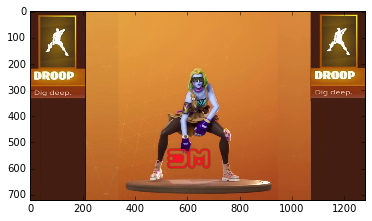

In [21]:
test_image = ROOT + "frames/test3/test_139.jpg"
img = cv2.imread(test_image)
plt.imshow(img)
plt.show()

Not sure why that's appearing orange? Let's with PIL instead..

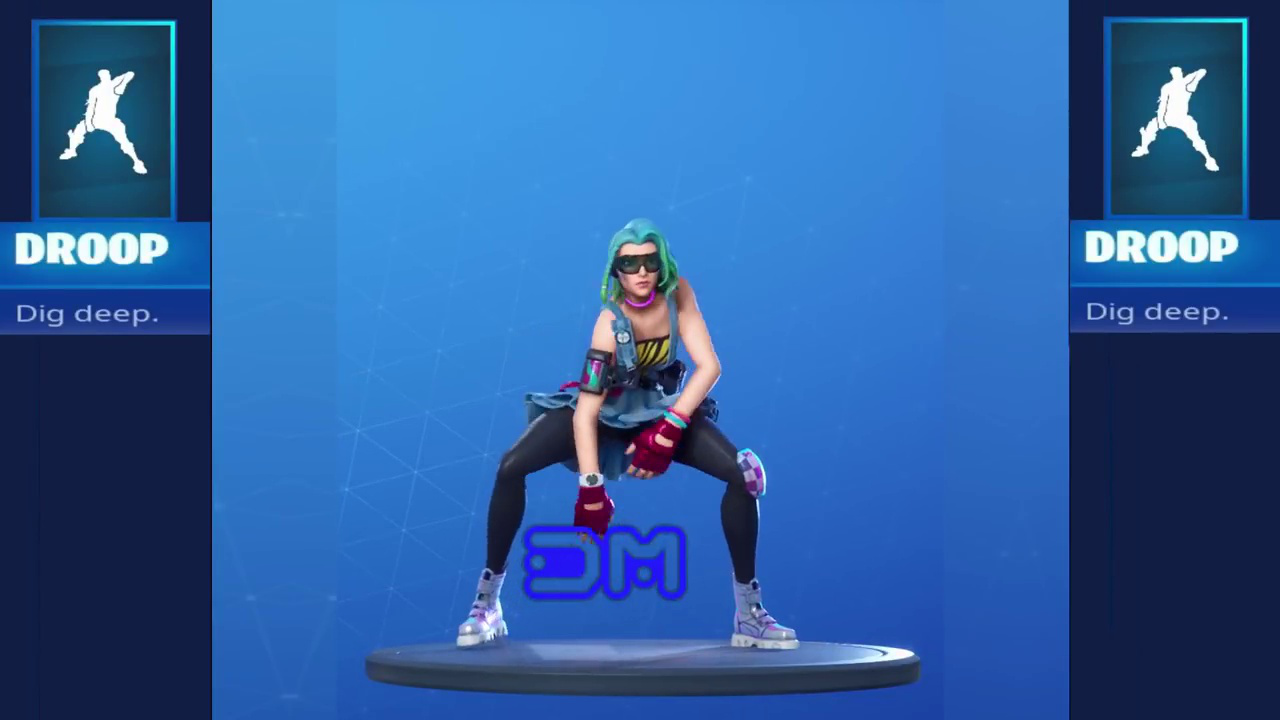

In [32]:
from PIL import Image

Image.open(test_image)

### Change Contrast
Thanks to this stackoverflow [hero](https://stackoverflow.com/questions/42045362/change-contrast-of-image-in-pil)

In [41]:
def change_contrast(img, level=100):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    
    def contrast(c):
        return 128 + factor * (c - 128)
    
    img = img.point(contrast)
    return img

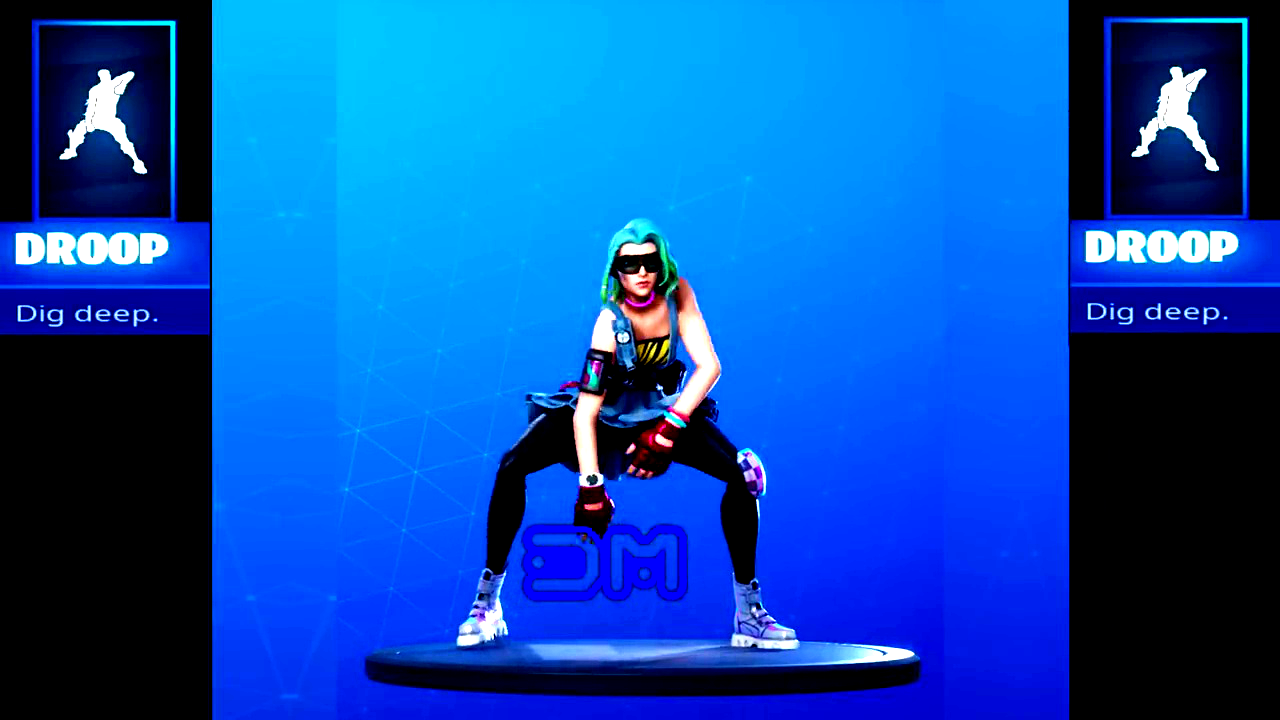

In [31]:
change_contrast(Image.open(test_image))

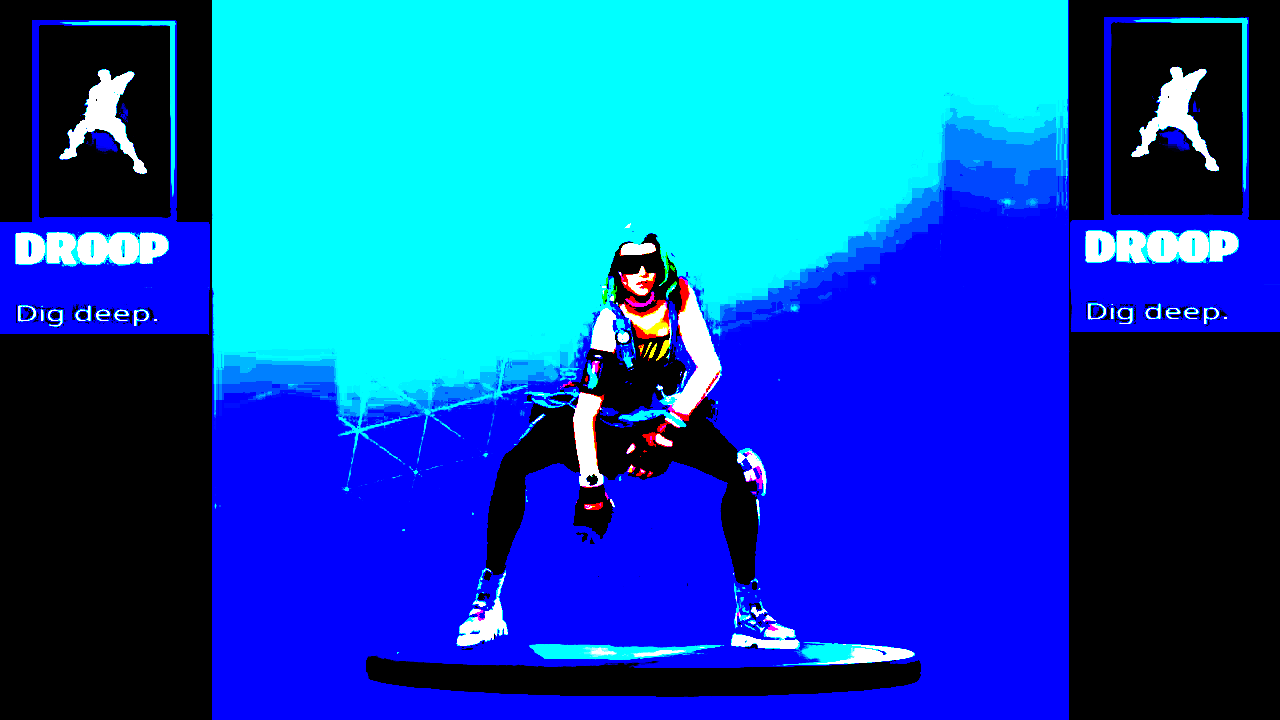

In [36]:
change_contrast(Image.open(test_image), 250)

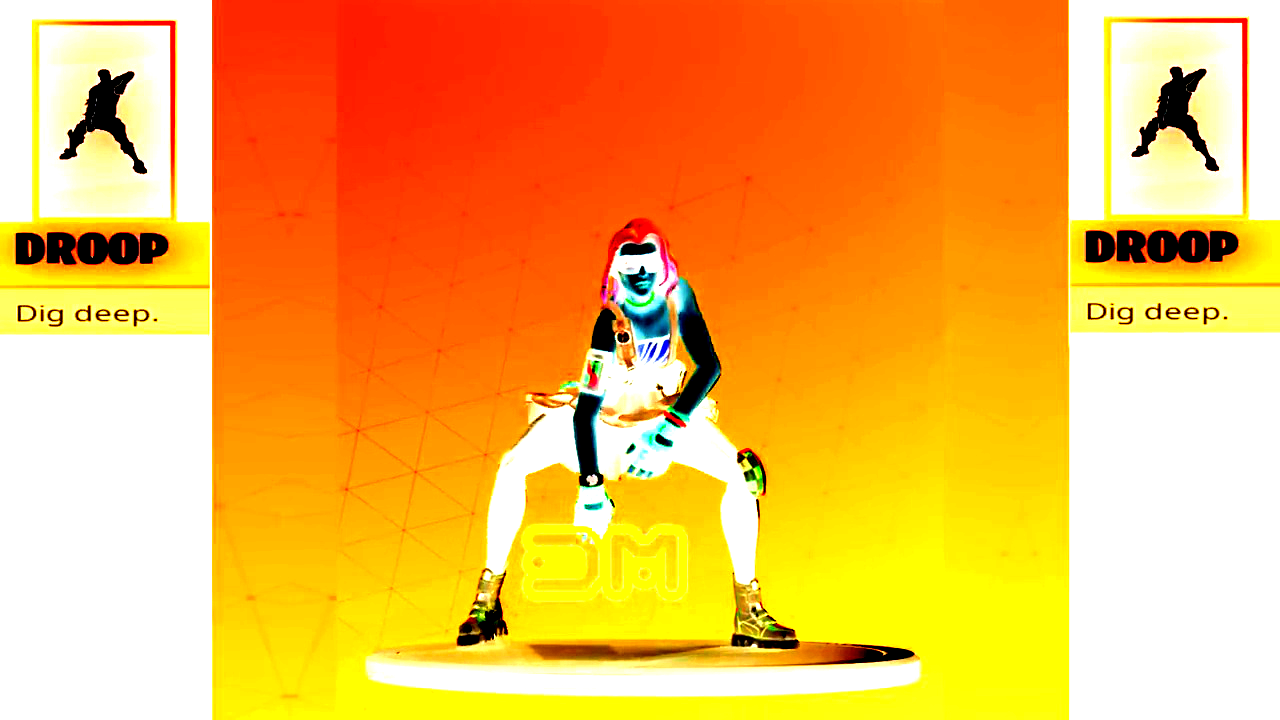

In [42]:
change_contrast(Image.open(test_image), 500)

#### Contrast Review
I like the `200` level contrast change; I think that's what was closest to the desired effect. Let's remove the pixels now!

### Remove Cyan and Blue

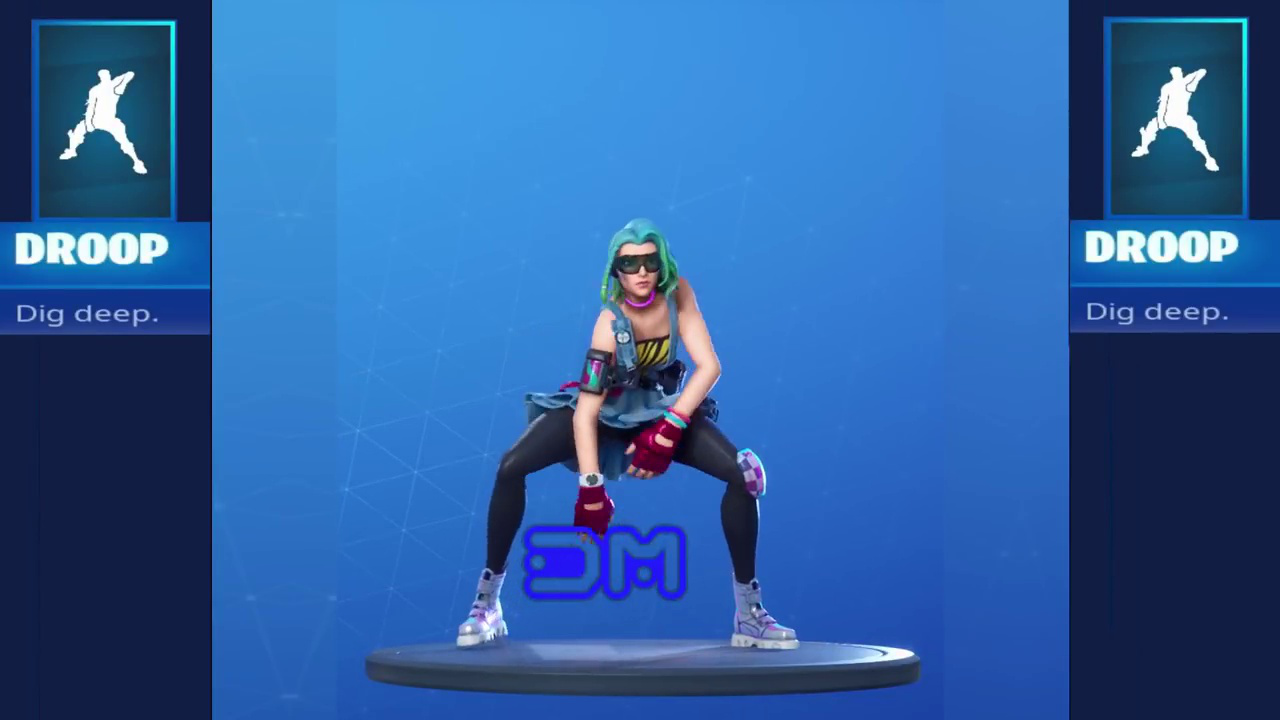

In [109]:
Image.open(test_image)

In [96]:
BLUE = (0, 0, 255)
CYAN = (0, 255, 255)
WHITE = (255, 255, 255)
ORANGE = (255, 99, 71)

def remove_color(img, rgb_remove, rgb_replace):
    width, height = img.size
    
    for x in range(width):
        for y in range(height):
            current_color = img.getpixel((x, y))
            
            if current_color == rgb_remove:
                img.putpixel((x, y), rgb_replace)
    
    return img

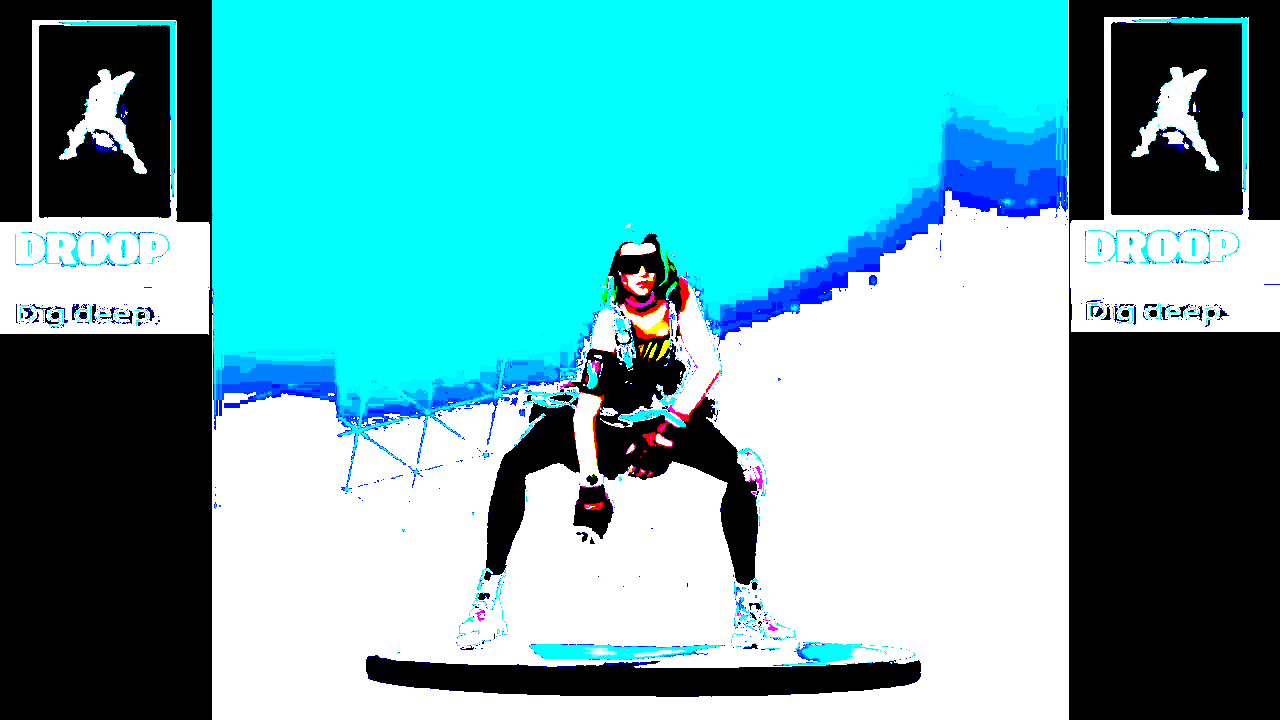

In [97]:
no_blue = Image.open(test_image)
no_blue = change_contrast(no_blue, 250)

no_blue = remove_color(no_blue, BLUE, WHITE)
no_blue

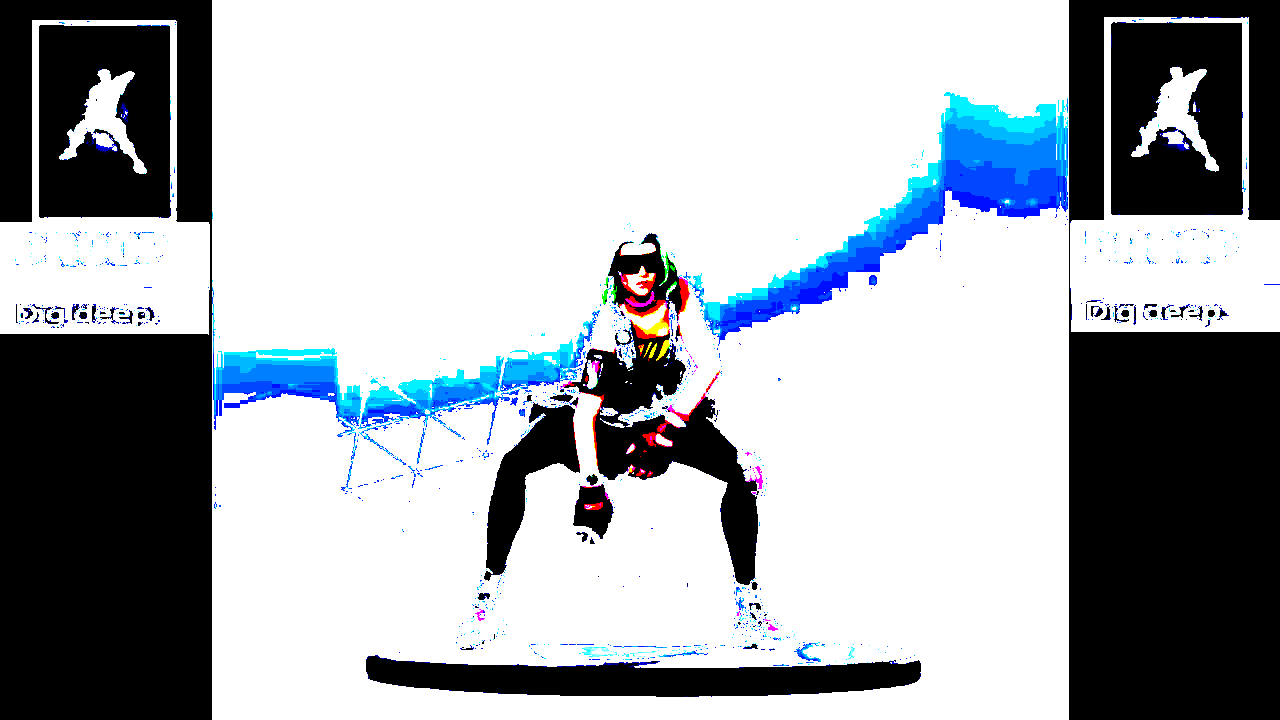

In [98]:
no_cyan = no_blue
no_cyan = remove_color(no_cyan, CYAN, WHITE)
no_cyan

In [99]:
BLUE = (0, 0, 255)
CYAN = (0, 255, 255)
WHITE = (255, 255, 255)
ORANGE = (255, 99, 71)

def remove_colors(img, rgb_remove, rgb_replace):
    width, height = img.size
    
    for x in range(width):
        for y in range(height):
            current_color = img.getpixel((x, y))
            
            if current_color in rgb_remove:
                img.putpixel((x, y), rgb_replace)
#             else:
#                 img.putpixel((x, y), ORANGE)
    
    return img

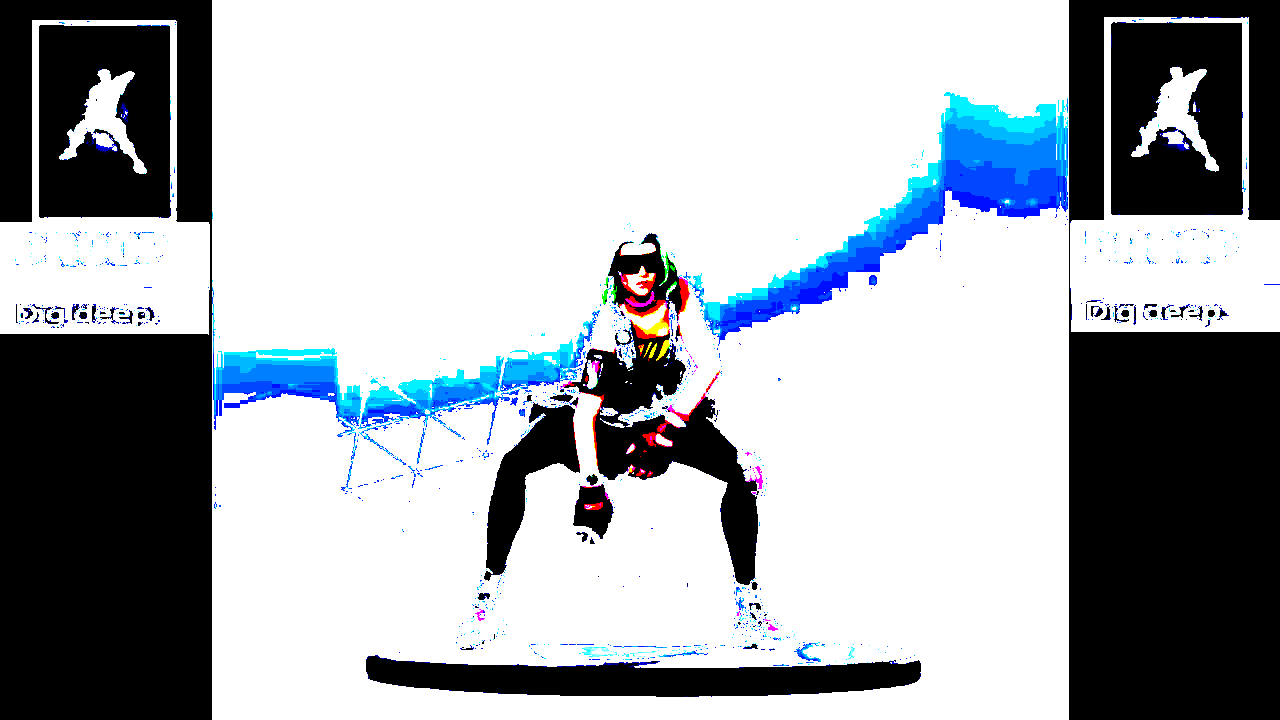

In [120]:
BLUE_1 = (31, 72, 242)
BLUE_2 = (56, 126, 243)
BLUE_3 = (143, 240, 249)
BLUES = [BLUE, BLUE_1, BLUE_2, BLUE_3, CYAN]

clean = Image.open(test_image)
clean = change_contrast(clean, 250)
clean = remove_colors(clean, BLUES, WHITE)
clean    

In [121]:
def remove_blues(img, rgb_replace):
    width, height = img.size
    print(width, height)
    
    for x in range(width):
        for y in range(height):
            current_color = img.getpixel((x, y))
            
            if current_color[2] > 200:
                img.putpixel((x, y), rgb_replace)
            else:
                img.putpixel((x, y), ORANGE) 
    
    return img

1280 720


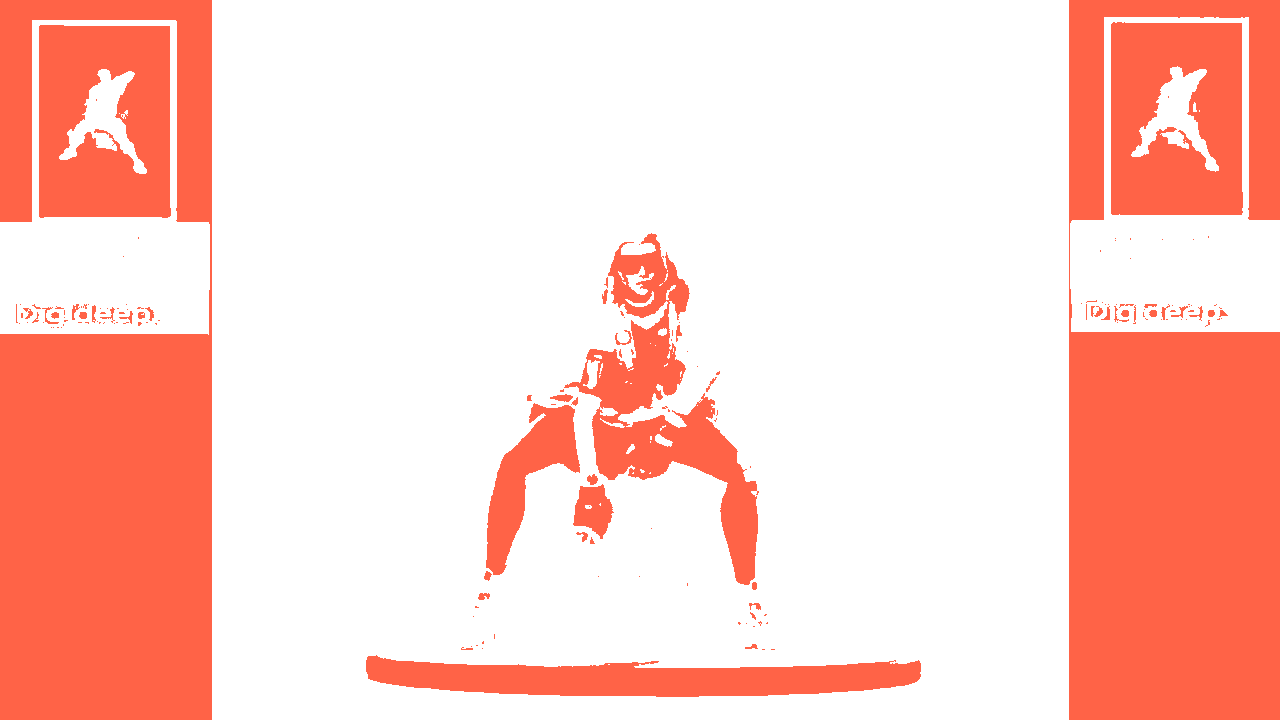

In [122]:
clean = remove_blues(clean, WHITE)
clean    

yay!

### Cropping

In [125]:
def my_crop(img):
    width, height = img.size
    
    left = 1
    top = 1
    right = 1
    bottom = 1
    
    img = img.crop((left, top, right, bottom))
    return img

In [126]:
cropped = my_crop(clean)
cropped

SystemError: tile cannot extend outside image

<PIL.Image._ImageCrop image mode=RGB size=0x0 at 0x13A3015C0>

## Final Binary Image Conversion
Except for crop but we'll figure that out

In [130]:
def binary_image_conv(input_path):
    img = Image.open(input_path)
    img = change_contrast(img, 250)
    img = remove_colors(img, BLUES, WHITE)
    img = remove_blues(img, WHITE)
    return img

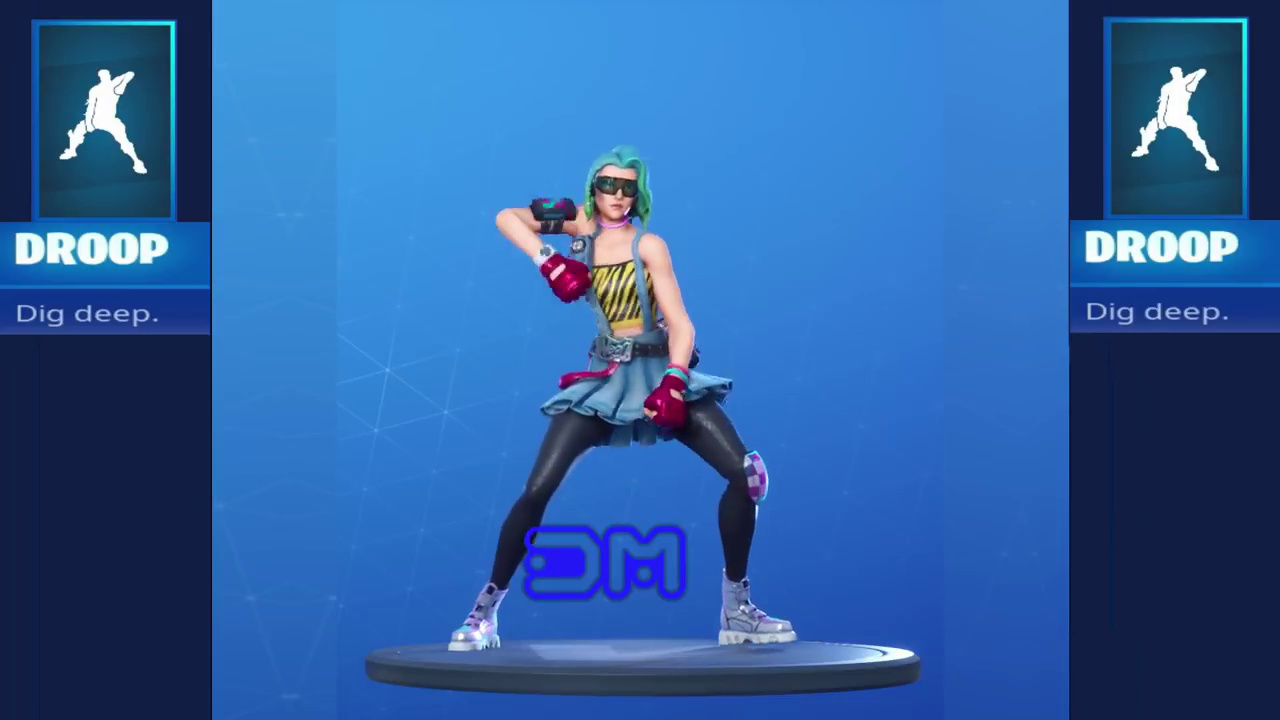

In [131]:
input_path = ROOT + "frames/test3/test_312.jpg"
Image.open(input_path)

1280 720


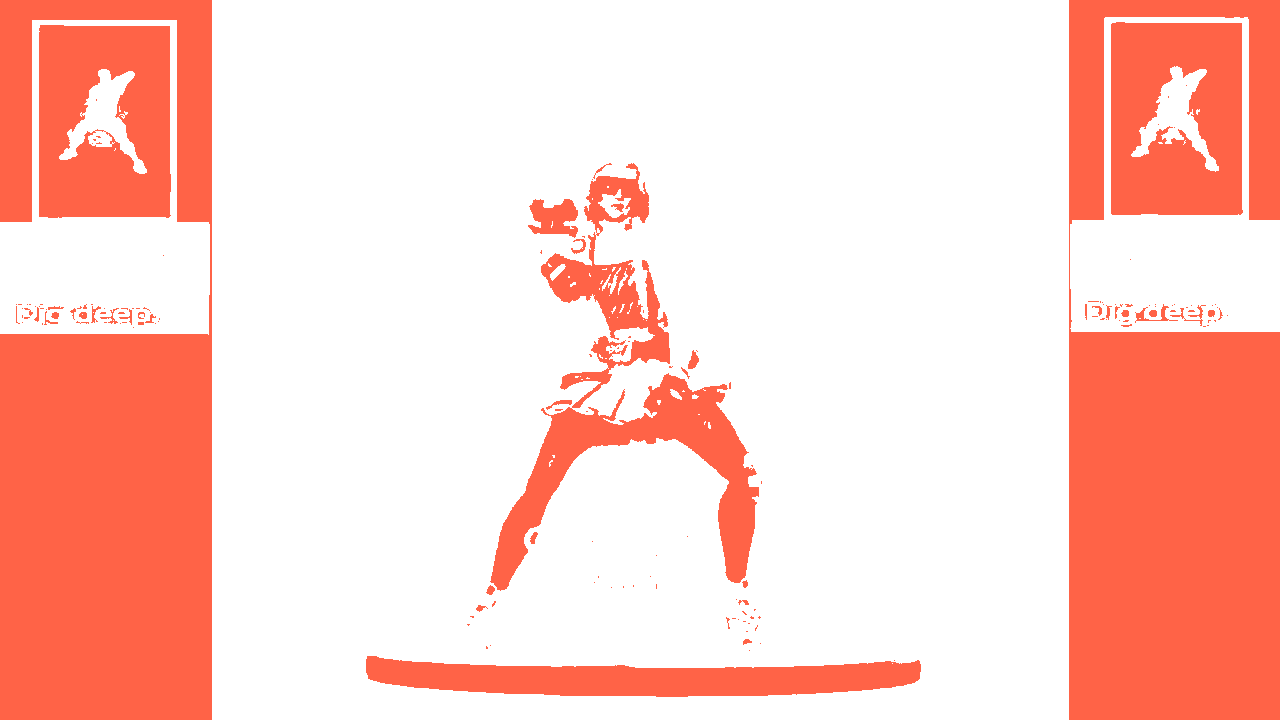

In [132]:
img = binary_image_conv(input_path)
img